In [1]:
from pydub import AudioSegment
import numpy as np
from scipy import signal
from matplotlib import pyplot as plt

In [2]:
filePath = "EUDC 2015 Round 6 A.mp3"

In [18]:
originalAudio = AudioSegment.from_mp3(filePath)

frameRate = originalAudio.frame_rate

leftChannel = originalAudio.split_to_mono()[0]
rightChannel = originalAudio.split_to_mono()[1]
mergedAudio = leftChannel.overlay(rightChannel)

In [44]:
ARRAY_TYPES = {
    8:  np.int8,
    16: np.int16,
    32: np.int32,
    64: np.int64
}

# Each byte is 8 bits wide. Sample width in bytes.
quantizationLevel = ARRAY_TYPES[originalAudio.sample_width * 8]

# Converting audio into a format processable using numpy.
singleChannelAudio = np.frombuffer(mergedAudio.raw_data, dtype=quantizationLevel)

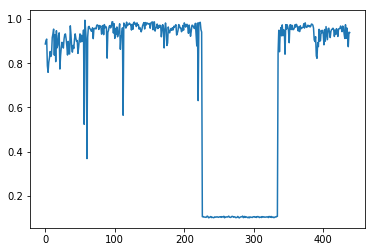

In [45]:
# Windows of 10 seconds each.
windowWidth = frameRate*10
windowOverlap = int(windowWidth/10.0)

trackedFrequencies, centresOfWindows, energyPerFrequencyPerWindow = \
                signal.spectrogram(singleChannelAudio,
                                    frameRate,
                                    window=('tukey', 0.25),
                                    nperseg=windowWidth,
                                    noverlap=windowOverlap,
                                    scaling='spectrum')
    
numberOfWindows = centresOfWindows.shape[0]

# Extract indices of frequencies between 40Hz and 4000Hz.
indexOf40 = 0
indexOf4000 = 0
for (i, freq) in enumerate(trackedFrequencies):
    if freq < 40:
        indexOf40 = i + 1
    if freq < 4000:
        indexOf4000 = i + 1

# Calculating the energy in voice frequencies and all frequencies of windows.
# 0: energy in voice frequencies; 1: total energy, 2: fraction of 1 in 2
energiesOfWindows = np.zeros(shape=(numberOfWindows, 3))
for w in range(numberOfWindows):
    energyInVoiceBand = energyPerFrequencyPerWindow[np.arange(indexOf40, indexOf4000, dtype=np.int), w].sum()
    totalEnergy = energyPerFrequencyPerWindow [:, w].sum()
    energiesOfWindows[w, 0] = np.power(energyInVoiceBand, 2)
    energiesOfWindows[w, 1] = np.power(totalEnergy, 2)
    energiesOfWindows[w, 2] = energiesOfWindows[w, 0] / energiesOfWindows[w, 1]

plt.plot(np.arange(0, numberOfWindows), energiesOfWindows[:, 2])
plt.show()

In [22]:
# Fraction of energy in voice band for a window to be identified as containing voice.
# This basically means that a whole 10 second period (or any other window size) has
# less than 60% voice.
voiceThreshold = 0.6

# true: voice; false: no voice
flaggedWindows = energiesOfWindows[:, 2] > 0.6
# Centres of windows are in seconds. Converting them to array indices.
centreIndicesOfWindows = centresOfWindows * frameRate

# Setting all indices of a window to the corresponding flag.
flaggedIndices = np.full((singleChannelAudio.shape[0], 1), True)
for (i, index) in enumerate(centreIndicesOfWindows):
    windowStartIndex = int(index - (windowWidth/2))
    windowEndIndex = int(index + (windowWidth/2))
    flaggedIndices[windowStartIndex:windowEndIndex] = flaggedWindows[i]

In [27]:
# Reshape is necessary to fix 2nd dimension for indexing.
cutAudio = singleChannelAudio.reshape((-1, 1))[flaggedIndices]

In [61]:
AudioSegment(
    # raw audio data (bytes)
    data=cutAudio.tobytes(),

    sample_width=np.iinfo(quantizationLevel) / 8,

    frame_rate=frameRate,

    channels=1
).export("shortened"+filePath, format="mp3")

<open file 'shortenedEUDC 2015 Round 6 A.mp3', mode 'wb+' at 0x1125eb8a0>